In [2]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip3 install tdmclient --upgrade

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, clear_output
import time
import math

In [123]:
def find_camera_index(i):
    cap = cv2.Videocapture(i)
    if cap.isOpened():
        print(f"Camera index {i} found.")
        cap.release()
        return(i)
    else:
        print(f"No camera found at index {i}.")
        return find_camera_index(i+1)

def show_frame(frame):
    _, img_encoded = cv2.imencode('.png', frame)
    IPython.display.display(IPython.display.Image(data=img_encoded.tobytes()))

def vector_to_angle(vector):
    angle = math.atan2(vector[1], vector[0])
    return angle

def upper_lower_color(color, c):
    mean, stddev = cv2.meanStdDev(color)
    # Define the color range for the object (in this case, blue)
    lower_color = mean - c*stddev
    upper_color = mean + c*stddev

    return lower_color, upper_color

def mask(frame, color,c):
    lower_b, upper_b = upper_lower_color(color, c)
    return cv2.inRange(frame, lower_b, upper_b)

def find_contours(frame, color,c):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask(frame, color,c), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

class Obj:
    def __init__(self, color, size, c = 2,img_pos = np.array([[0,0]])):
        self.color = color
        self.size = size
        self.c = c
        self.img_pos = img_pos

    
    def detect_object(self, frame):
        contours = find_contours(frame, self.color,self.c)
        centroids = []
        for contour in contours:
        # Get the size of the contour
            area = cv2.contourArea(contour)
            # Set a threshold for the contour size to filter out small contours
            if area > self.size:
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append([cx, cy])
                    #x, y, w, h = cv2.boundingRect(contour)
                    
                    # Draw a circle at the centroid
                    #cv2.circle(frame, centroid, 5, (0, 255, 0), -1)
                    
                    """ # Get bounding box coordinates
                    x, y, w, h = cv2.boundingRect(contour)
                    
                    # Draw a rectangle around the object
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    """
        if len(centroids) > 0:
            self.img_pos = np.array(centroids)
        return
    
    def get_img_pos(self, frame):
        self.detect_object(frame)
        return self.img_pos
    
    def draw(self, frame, color):
        if np.size(self.get_img_pos(frame),0) > 0:
            pos = self.img_pos.tolist()
            for o in range(len(pos)):
                cv2.circle(frame, pos[o], 20, color, -1)
        #else:
            #print('No object')
        return

        
        
    
class Map:
    def __init__(self, ref1, ref2, ref3, distance_r1r2 = 400, distance_r3r2 = 400):
        self.ref1 = ref1
        self.ref1_position  = np.array([1, 0])
        self.ref2 = ref2
        self.ref2_position = np.array([0, 0])
        self.ref3 = ref3
        self.ref3_position = np.array([0, 1])
        self.origin = np.array([0, 0])
        self.e1 = (self.ref1_position - self.ref2_position)/np.linalg.norm(self.ref1_position - self.ref2_position)
        self.e2 = (self.ref3_position - self.ref2_position)/np.linalg.norm(self.ref3_position - self.ref2_position)
        self.scale1 = distance_r1r2/np.linalg.norm(self.ref1_position - self.ref2_position)
        self.scale2 = distance_r3r2/np.linalg.norm(self.ref3_position - self.ref2_position)
        
    def loc_img2map(self, frame, img_coordinates):
        # Interpretation of an image thanks to the map
        r1_img_pos = self.ref1.get_img_pos(frame)[0]
        r2_img_pos = self.ref2.get_img_pos(frame)[0]
        r3_img_pos = self.ref3.get_img_pos(frame)[0]
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        
        map_coordinates = np.array([np.dot(img_coordinates-r2_img_pos, e1_img)/np.dot(e1_img,e1_img), 
        np.dot(img_coordinates-r2_img_pos, e2_img)/np.dot(e2_img,e2_img)])

        return map_coordinates
    
    def vec_img2map(self, frame, img_coordinates):
        # Interpretation of an image thanks to the map
        r1_img_pos = self.ref1.get_img_pos(frame)[0]
        r2_img_pos = self.ref2.get_img_pos(frame)[0]
        r3_img_pos = self.ref3.get_img_pos(frame)[0]
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        
        map_coordinates = np.array([np.dot(img_coordinates, e1_img)/np.dot(e1_img,e1_img), 
        np.dot(img_coordinates, e2_img)/np.dot(e2_img,e2_img)])

        return map_coordinates
    
    def map2img(self, frame, map_coordinates):
        r1_img_pos = self.ref1.get_img_pos(frame)[0]
        r2_img_pos = self.ref2.get_img_pos(frame)[0]
        r3_img_pos = self.ref3.get_img_pos(frame)[0]
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        img_coordinates = np.round(r2_img_pos + map_coordinates[0]*e1_img + map_coordinates[1]*e2_img).astype(int)

        return img_coordinates
    
    def localize(self, frame, obj):
        img_coordinates = obj.get_img_pos(frame)[0]
        map_pos = self.loc_img2map(frame, img_coordinates)
        return map_pos


class Robot:
    def __init__(self, left_mark, right_mark, position = np.array([0, 0]), direction = np.array([0, 0])):
        self.left_mark = left_mark
        self.right_mark = right_mark
        self.position = position
        self.direction = direction

    def robot_tracking(self, frame):
        lm_img_pos = self.left_mark.get_img_pos(frame)[0]
        rm_img_pos = self.right_mark.get_img_pos(frame)[0]

        robot_img_pos = np.array([(lm_img_pos[0] + rm_img_pos[0])//2, (lm_img_pos[1] + rm_img_pos[1])//2])
        robot_img_direction = np.array([-(lm_img_pos[1] - rm_img_pos[1]), (lm_img_pos[0] - rm_img_pos[0])])
        return np.array([robot_img_pos, robot_img_direction])
    
    def update_localization(self, frame, map):
        robot_img_pos = self.robot_tracking(frame)[0]
        robot_img_direction = self.robot_tracking(frame)[1]
        self.position = map.loc_img2map(frame, robot_img_pos)
        dir = map.vec_img2map(frame, robot_img_direction)
        self.direction = dir/np.linalg.norm(dir)
        return
    
    def robot_localization(self, frame, map):
        self.update_localization(frame, map)
        return np.array([self.position, self.direction])


def object_highlight(drawing, original_frame, object2):
    img_coordinates = object2.get_img_pos(original_frame)[0]
    cv2.rectangle(drawing, [img_coordinates[0] - object2.width // 2, img_coordinates[1] - object2.height // 2], 
                    [img_coordinates[0] + object2.width // 2, img_coordinates[1] + object2.height // 2], (200, 0, 0), -1)
    return



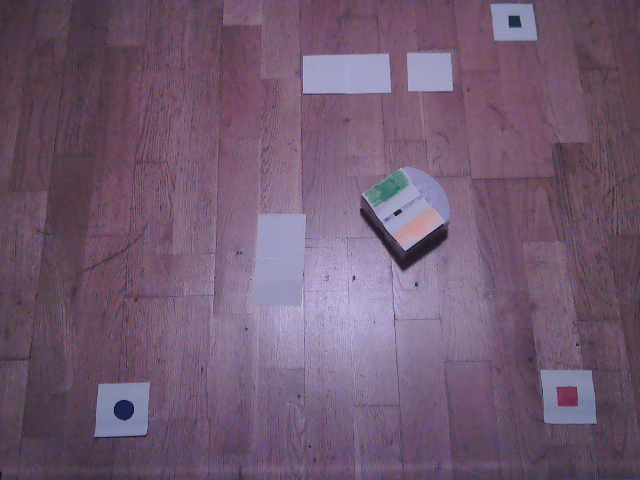

In [85]:
i = 0
cap = cv2.VideoCapture(i)
# Check if camera opened successfully
""" while not cap.isOpened():
    cap = cv2.VideoCapture(i)
    print(f"No camera found at index {i}.")
    i += 1
 """
video_imgs = []
titles = []


for i in range(500):
    ret, frame = cap.read()
    if ret == True:
        #cv2.line(copy, robot.robot_tracking(frame)[0], np.add(robot.robot_tracking(frame)[0],robot.robot_tracking(frame)[1]), (255, 0, 0), 2)
        video_imgs.append(frame)

        show_frame(frame)
        #time.sleep(1)

        clear_output(wait=True)

frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
   
size = (frame_width, frame_height)
video = cv2.VideoWriter('test_tracking.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
for f in range(len(video_imgs)):
    video.write(video_imgs[f])


        

[[ 0.27870658  0.37033527]
 [-0.57792952 -0.81608668]]


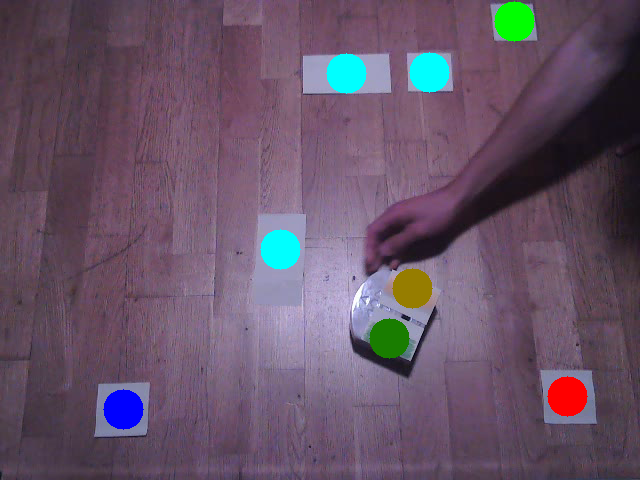

KeyboardInterrupt: 

In [126]:

color_ref1 = cv2.imread('ref1.jpg')
ref1 = Obj(color_ref1, 40)

color_ref2 = cv2.imread('ref2.jpg')
ref2 = Obj(color_ref2, 70, 1.5)

color_ref3 = cv2.imread('ref3.jpg')
ref3 = Obj(color_ref3, 70)

color_obstacle = cv2.imread('obstacle.jpg')
obstacle = Obj(color_obstacle, 1300, 4.5)

color_left_mark = cv2.imread('left_mark.jpg')
left_mark = Obj(color_left_mark, 150)

color_right_mark = cv2.imread('right_mark.jpg')
right_mark = Obj(color_right_mark, 150)

map = Map(ref1, ref2, ref3)

thymio = Robot(right_mark, left_mark)

video = cv2.VideoCapture('test_tracking.avi')
if (video.isOpened()== False): 
  print("Error opening video stream or file")

# Read until video is completed
while(video.isOpened()):
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret == True:
        copy_f = frame.copy()
        
        ref1.draw(copy_f,(0, 255, 0))
        ref2.draw(copy_f,(0,0,255))
        ref3.draw(copy_f,(255, 0, 0))
        obstacle.draw(copy_f, (255, 255, 0))
        left_mark.draw(copy_f, (0, 125, 25))
        right_mark.draw(copy_f, (0, 125, 150))

        
        
        print(thymio.robot_localization(frame, map))
        #show_frame(frame)
        show_frame(copy_f)
        time.sleep(0.3)

        clear_output(wait=True)
    
 
  # Break the loop
    else: 
        break
 
# When everything done, release the video capture object
video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [86]:
cv2.imwrite('objects.jpg',frame)

True